# Molecular Dynamics

## Overview

**Questions**
- How does a molecular dynamics algorithm work?

**Objectives**
- Develop an understanding of the fundamentals of molecular dynamics
- Construct a simple one-dimensional MD simulation from scratch

Now that we have introduced the classical potential models, and how these models are obtained, we can start to look at the dynamics of the system. 

## Force and acceleration
The particles that we study are classical in nature, and therefore it is possible to apply classical mechanics to rationalise their dynamic behaviour. 
For this the starting point is **Newton's second law of motion**, 

$$ \mathbf{f} = m\mathbf{a}, $$

where $\mathbf{f}$ is the force on an atom of mass, $m$, and acceleration, $\mathbf{a}$. 
The force between two particles, $i$ and $j$, can be found from the interaction energy, 

$$ f_{ij} = \dfrac{-\text{d}E(r_{ij})}{\text{d}r_{ij}}.$$

Which is to say that the force is the negative of the first derivative of the energy with respect to the distance between them.
The Python code below creates a new function that is capable of calculating the force from the Lennard-Jones potential. 
The force between the atoms is then plotted.

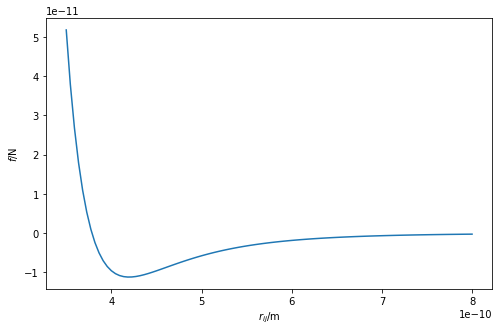

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def lj_force(rij, a, b):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    rij: float
        Distance between particles i and j
    a: float 
        A parameter for interaction between i and j
    b: float 
        B parameter for interaction between i and j
    
    Returns
    -------
    float
        Force of the interaction between i and j.
    """
    return 12 * a / np.power(rij, 13) - 6 * b / np.power(rij, 7)
    
r = np.linspace(3.5e-10, 8e-10, 100)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(r, lj_force(r, 1.363e-134, 9.273e-78))
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$f$/N')
plt.show()

You may have noticed that in Newton's second law of motion, the force is a vector quantity, whereas the first negative derivative of the energy is a scalar.
This means that it is necessary to convert to obtain the force vector for the relevant dimensionality. 
This is achieved by multiplication by the unit vector in each dimension,

$$ \mathbf{f}_x = f\hat{\mathbf{r}}_x\text{, where }\hat{\mathbf{r}}_x = \dfrac{r_x}{|\mathbf{r}|}. $$

In the above equation, $r_x$ is the distance between the two particles in the $x$-dimension and $\mathbf{r}$ is the overall distance vector. 
The above equation must be determined to find the force in each dimension. 
However, this lesson will **only** consider particles interacting in a one-dimensional space. 

The Python code below shows how to determine the acceleration on each atom of argon due to each other atom of argon. 
Due to Newton's third law, we are able to **increase the efficiency** of this algorithm as the force on atom $i$ will be equal and opposite to the force on atom $j$. 

In [3]:
mass_of_argon = 39.948 # amu
mass_of_argon_kg = mass_of_argon * 1.6605e-27

def get_accelerations(positions):
    """
    Calculate the acceleration on each particle as a 
    result of each other particle. 
    N.B. We use the Python convention of numbering from 0.
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, for all
        of the particles
        
    Returns
    -------
    ndarray of floats
        The acceleration on each particle
    """
    accel_x = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size - 1):
        for j in range(i + 1, positions.size):
            r_x = positions[j] - positions[i]
            rmag = np.sqrt(r_x * r_x)
            force_scalar = lj_force(rmag, 1.363e-134, 9.273e-78)
            force_x = force_scalar * r_x / rmag
            accel_x[i, j] = force_x / mass_of_argon_kg
            accel_x[j, i] = - force_x / mass_of_argon_kg
    return np.sum(accel_x, axis=0)

accel = get_accelerations(np.array([1e-10, 5e-10, 10e-10]))
print('Acceleration on particle 0 = {:.3e} m/s'.format(accel[0]))
print('Acceleration on particle 1 = {:.3e} m/s'.format(accel[1]))
print('Acceleration on particle 2 = {:.3e} m/s'.format(accel[2]))

Acceleration on particle 0 = 1.463e+14 m/s
Acceleration on particle 1 = -5.736e+13 m/s
Acceleration on particle 2 = -8.891e+13 m/s


## Integration

Now that we have seen how to obtain the acceleration on our particles, we can consider applying the **Newtonian equations of motion** to probe the particles trajectory, 

$$ \mathbf{x}_i(t + \Delta t) = \mathbf{x}_i(t) + \mathbf{v}_i(t)\Delta t + \dfrac{1}{2} \mathbf{a}_i(t)\Delta t^2, $$

$$ \mathbf{v}_i(t + \Delta t) = \mathbf{v}_i(t) + \dfrac{1}{2}\big[\mathbf{a}_i(t) + \mathbf{a}_i(t+\Delta t)\big]\Delta t, $$ 

where, $\Delta t$ is the timestep (how far in time is incremented), $\mathbf{x}_i$ is the particle position, $\mathbf{v}_i$ is the velocity, and $\mathbf{a}_i$ the acceleration. 
This pair of equations is known as the Velocity-Verlet algorithm, which can be written as:

1. Find the position of the particle after some timestep
2. Calculate the force (and therefore acceleration) on the particle
3. Determine a new velocity for the particle, based on the average acceleration at the current and new positions
4. Overwrite the old acceleration values with the new ones, $\mathbf{a}_i(t) = \mathbf{a}_i(t+\Delta t)$
5. Go to 1

This process can be continued for as long as is required to get **good statistics** for the quantity you are intereseting in (or for as long as you can wait for/afford to run the computer for). 

The Python code below is a set of two function for the above equations, these will be applied later.

In [4]:
def update_pos(x, v, a, dt):
    """
    Update the particle positions.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a single dimension
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a single dimension
    """
    return x + v * dt + 0.5 * a * dt * dt

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension 
        at the previous timestep
    a1: ndarray of floats
        The accelerations of the particles in a single dimension
        at the current timestep
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a single dimension
    """
    return v + 0.5 * (a + a1) * dt

The above process is called the intergration step, and Velocity-Verlet is the **integrator**. 
In essence, the function that is being integrated is the acceleration on the particular atom at a given time. 
This function is highly non-linear for more than one particle. 
The result is that the integration step will only be valid for very small values of $\Delta t$, e.g. if a large timestep is used the acceleration calculated will not be accurate as the forces on the atom will change too significantly during it. 
The value for the timestep is usually on the order of 10<sup>-15</sup> s (femtoseconds). 
So in order to measure a nanosecond of "real-time" molecular dynamics, 1&nbsp;000&nbsp;000 (one million) iterations of the above algorithm must be performed. 
This can take a **very, very long time** for large, realistic systems.

## Initialisation

There are only **two tools** left that we need to run a molecular dynamics simulation, and both are associated with the original configuration of the system; the original particle positions, and the original particle velocities. 

The particle positions are usually either taken from some library of structures (e.g. the protein data bank if you are simulating proteins) or based on some knowledge of the system (e.g. CaF<sub>2</sub> is known to have a face-centred cubic structure). 
For complex, multicomponent systems software, such as Packmol [1], may be used to build up the structure from its constituent parts.
The importance of this initial structure **cannot be overstated**.
For example if the initial structure is very far form the equilibrium structure, it may take a very long time before the equilibrium structure is obtained, possibly much longer than can be reasonably simulated. 

The particle velocities are more general, as the total kinetic energy, $E_K$ of the system (and therefore the particle velocities) are dependent on the temperature of the simulation, $T$. 

$$ E_K = \sum_{i=1}^N \dfrac{m_i|v_i|^2}{2} = \dfrac{3}{2}Nk_BT, $$

where, $m_i$ is the mass of particle $i$, $N$ is the number of particles, and $k_B$ is the Boltzmann constant. 
Based on this information, the **most common way** to obtain initial velocities is to assign random values and then scale them dependent on the temperature of the system. 
For example, in a common method for the initial velocity determinaiton is as follows, 

$$ v_i = R_i \sqrt{\dfrac{k_BT}{m_i}}, $$

where $R_i$ is some random number between $-0.5$ and $0.5$, $k_B$ is the Boltzmann constant, $T$ is the temperature, and $m_i$ is the mass of the particle.

This method is implemented in the Python function below. 

In [5]:
from scipy.constants import Boltzmann

def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series of particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at initialisation
    number_of_particles: int
        Number of particles in the system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of particles
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt(Boltzmann * T / mass_of_argon_kg)

## Build an MD simulation

We can now use the functions defined above build a one-dimensional molecular dynamics simulation, using the Python code below. 

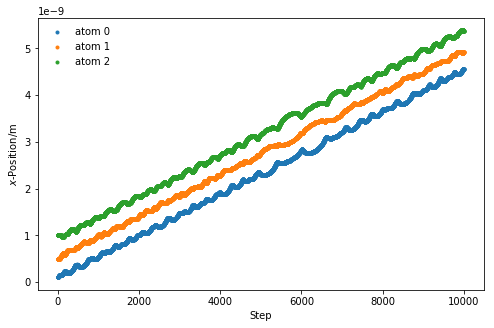

In [6]:
def run_md(dt, number_of_steps, initial_temp, x):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at initialisation
    x: ndarray of floats
        The initial positions of the particles in a single dimension
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles throughout the simulation
    """
    positions = np.zeros((number_of_steps, 3))
    v = init_velocity(initial_temp, 3)
    a = get_accelerations(x)
    for i in range(number_of_steps):
        x = update_pos(x, v, a, dt)
        a1 = get_accelerations(x)
        v = update_velo(v, a, a1, dt)
        a = np.array(a1)
        positions[i, :] = x
    return positions

sim_pos = run_md(1e-14, 10000, 300, np.array([1e-10, 5e-10, 1e-9]))
    
%matplotlib inline
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(sim_pos.shape[1]):
    ax.plot(sim_pos[:, i], '.', label='atom {}'.format(i))
ax.set_xlabel(r'Step')
ax.set_ylabel(r'$x$-Position/m')
ax.legend(frameon=False)
plt.show()

Generally the particles will follow each other through space. 
If you **build the simulation in your own Jupyter Notebook**, it is possible to run the simulation at a series of different initial starting positions by varying values in the array `x`. 

## Exercise: Kaboom!!

Try changing the initial particle positions to `[1e-10, 2e-10, 1e-9]`. 
The system will probably explode *explode*, consider why this has happened.


## Solution: Kaboom!!

Atom 0 and atom 1 have starting positions very close to each other, a distance of 1 Å. 
This means that the force between the particles is **very** large, pushing them apart. 
This system explosion is a common problem if the initial configuration is not correct. 

## Key Points
- Introduced to the basics of molecular dynamics simulation
- Understand the limitations on the timestep size available to molecular dynamics
- Be able to program a simple one-dimension MD simulation

# References

1. Martínez, L., Andrade, R, Birgin, E. G., & Martínez, J. M. (2009). J. Comput. Chem., **30**, 2157-2164 